# Strain rate steps

In [1]:
# Setting up environment
import sys
import pandas as pd
sys.path.append("../../xapres_package/")
import xapres as xa
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib
import gcsfs
import math

#xa = ApRESDefs.xapres(loglevel='debug')

In [45]:
# load relevant data
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

def reload_winter(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101 = reload_winter("A101").isel(attenuator_setting_pair=1)
ds_101_w = reload_winter("A101").isel(attenuator_setting_pair=1)
#ds_101 = xr.concat([ds_101,ds_101_w],'time')
ds_101.nbytes/1e9

ds_101 = xa.load.load_zarr().isel(time=slice(300,304), chirp_num=slice(0,1),attenuator_setting_pair=1)


In [4]:
# define function
def custom_stacked_profile_series(chirps,pad=2,F0=2e8,F1=4e8):
    StartFreq = 2e8
    StopFreq = 4e8
    B = StopFreq - StartFreq
    CentreFreq = B/2
    K = 2e8 
    dt = 1/40000
    c0 = 3e8 # speed of light in vaccuum
    ER_ICE = 3.18
    T0 = (F0-StartFreq)/K
    T1 = (F1-StartFreq)/K

    chirps = chirps.isel(chirp_time=range(math.ceil(T0/dt),math.floor(T1/dt)+1)).mean(dim='chirp_num')
    window = np.blackman(len(chirps.chirp_time))
    win_chirps = chirps*window
    Nt = len(chirps.chirp_time)
    Nfft = math.floor(Nt*pad)
    bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    padchirp = np.zeros((len(chirps.time),Nfft))
    padchirp[:,0:math.floor(Nt/2)] = win_chirps.data[:,math.floor(Nt/2):-1]
    padchirp[:,-math.floor(Nt/2):] = win_chirps.data[:,0:math.floor(Nt/2)]
    p = np.fft.fft(padchirp,axis=1)/Nfft * math.sqrt(2*pad)
    profile = p[:,0:math.floor(Nfft/2)-1]
    m = np.asarray([i for i in range(profile.shape[1])])/pad
    phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
    profile_ref = profile * np.exp(phiref[np.newaxis,:]*(-1j))
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    n = np.argmin(profile_range<=1400)
    Range = profile_range[:n]
    Profile = profile_ref[:,:n]
    da = xr.DataArray(Profile,
                  dims=['time','profile_range'],
                  coords={'profile_range': Range,
                         'time': chirps.time.data})
    return da

In [46]:
#ds_101 = ds_101.isel(time = slice(300,304), chirp_num=slice(0,1))
#ds_101

In [47]:
# Calculating profiles for a month
#ds_crop = ds_101#.isel(time=range(4600,4900))
#da_101_stacked  = custom_stacked_profile_series(ds_crop.chirp,2,3e8,4e8)


In [48]:
da_101_stacked = ds_101.profile_stacked

TypeError: No numeric data to plot.

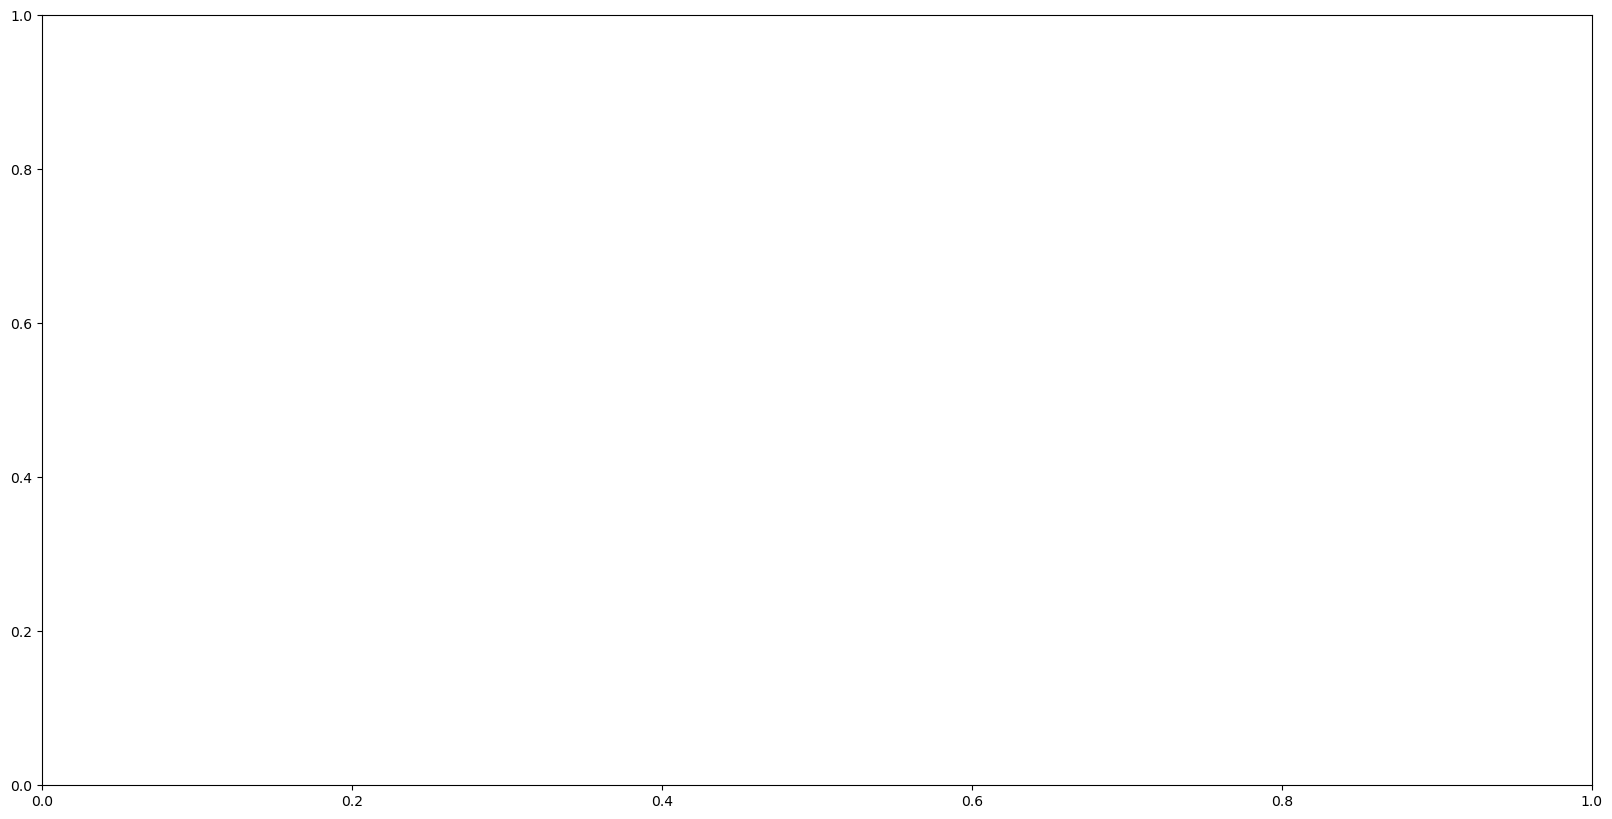

In [35]:
# Quick profile plot
fig, ax = plt.subplots(figsize=(20,10))
xa.utils.dB(da_101_stacked).plot(ax=ax,x='time',cbar_kwargs={'label':'Reflector amplitude [dB]'})
ax.invert_yaxis()
ax.set_title("Englacial reflector amplitudes")
plt.xlabel('date')


In [49]:
# Selecting staggered series of profiles
b1 = da_101_stacked.isel(time=range(0,len(da_101_stacked.time)-1)).compute()
b2 = da_101_stacked.isel(time=range(1,len(da_101_stacked.time))).compute()

Text(0.5, 0, 'Date of first burst in burst pair')

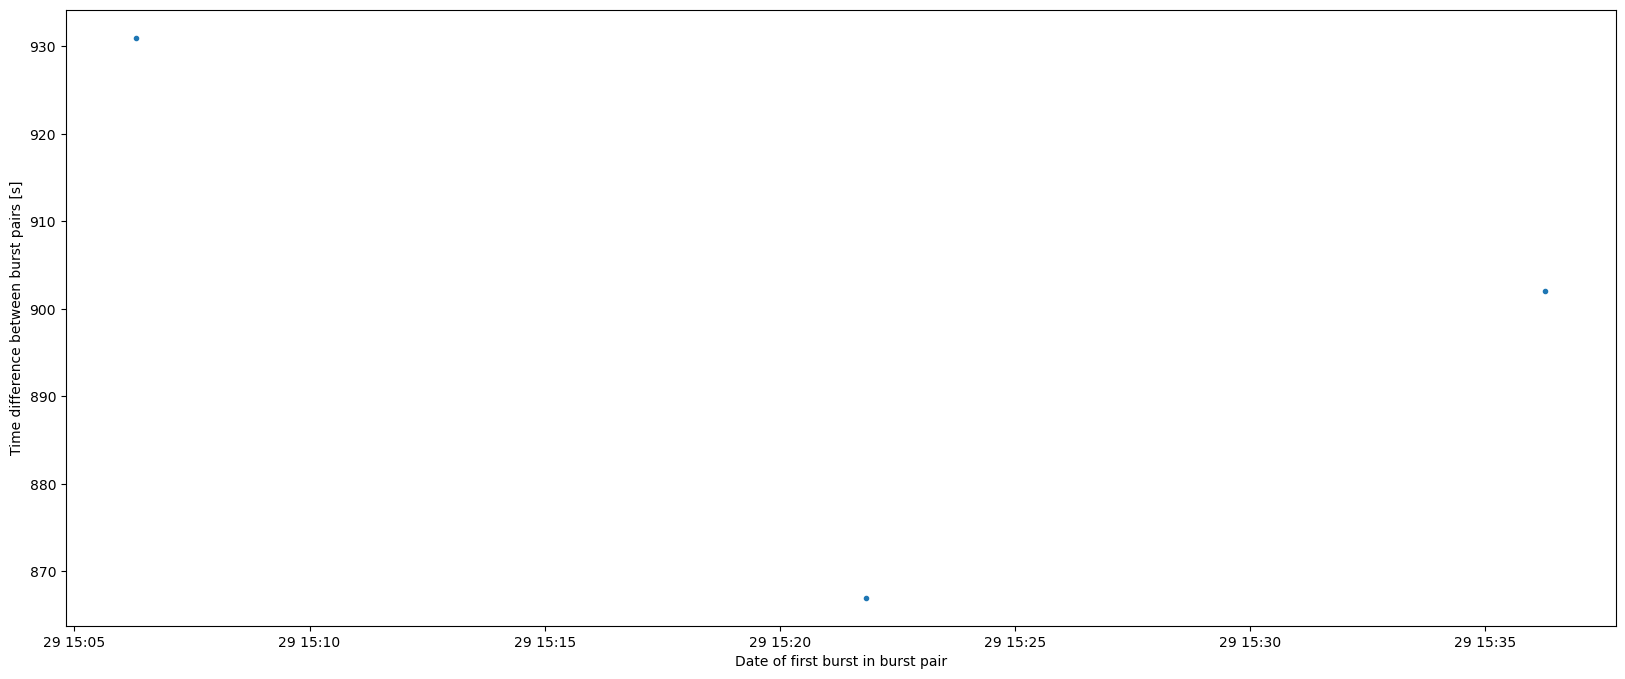

In [50]:
# Get timings
t1 = b1.time.data
t2 = b2.time.data
dt = (t2-t1)/ np.timedelta64(1, 's')
fig, ax = plt.subplots(figsize=(20,8))

plt.plot(t1,dt,linestyle='None',marker='.')
plt.ylabel('Time difference between burst pairs [s]')
plt.xlabel('Date of first burst in burst pair')

In [51]:
# Get phase difference
range_ext=None  
win_cor = 20
step = 20
if range_ext is not None:
    # Fill a depth array which will be more sparse than the full Range vector
    idxs = np.arange(win_cor//2, range_ext.shape[0]-win_cor//2, step).astype(int)
    ds = range_ext[idxs]
else:
    idxs = np.arange(win_cor//2, b1.shape[1]-win_cor//2, step).astype(int)
    ds = b1.profile_range[idxs]

Looks like this step is to sparsen the range of selected reflectors. It would be centering them around windows of 20 reflector bins.

In [52]:
len(b1.profile_range)

6658

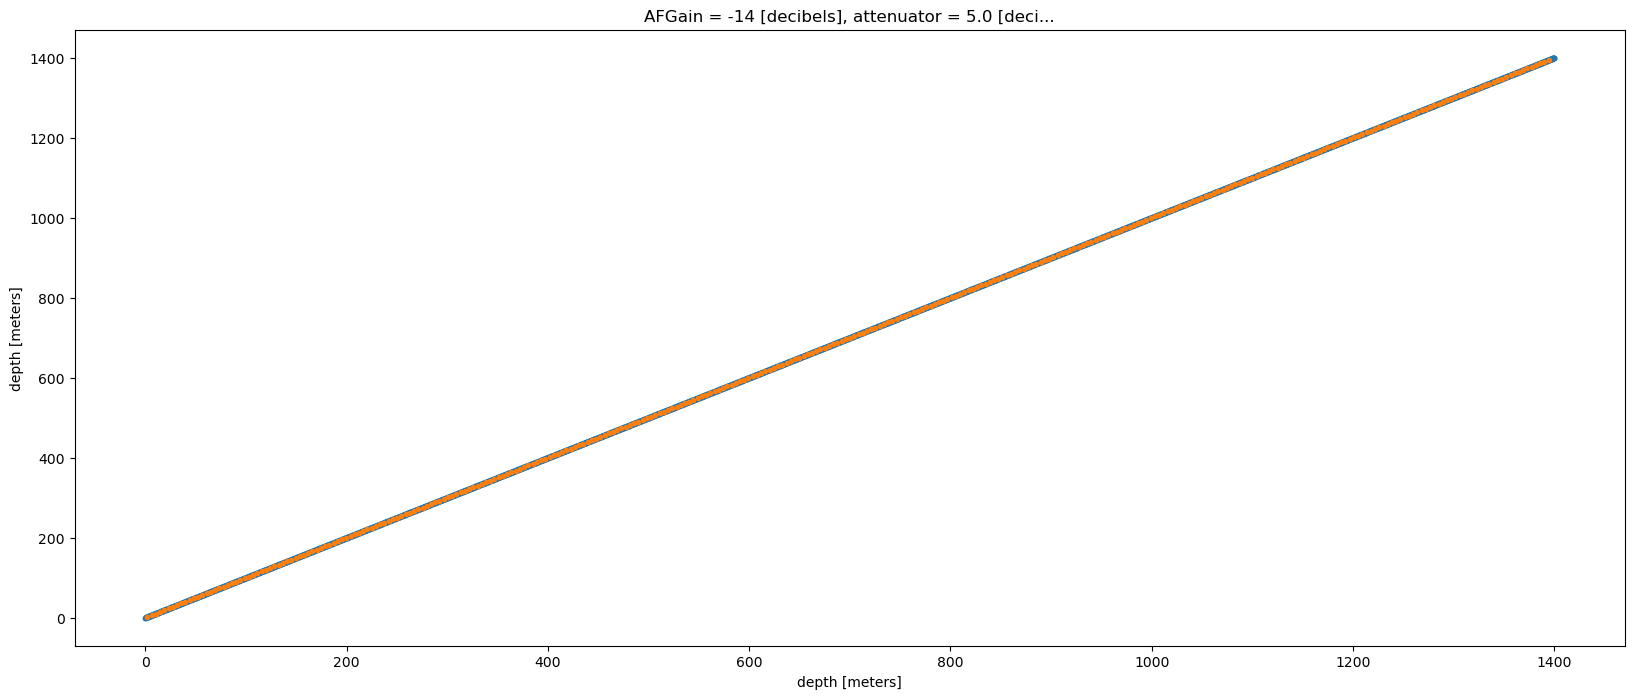

In [53]:
fig, ax = plt.subplots(figsize=(20,8))
b1.profile_range.plot(linestyle='None',marker='.')
ds.plot(linestyle='None',marker='.')

In [54]:
def coherence(s1, s2):
    """
    Phase correlation between two elements of the scattering matrix
    Jordan et al. (2019) eq. 13
    Parameters
    ---------
    s1: array
        first acquisition
    s2:
        second acquisition
    Output
    ---------
    c:  array
        phase coherence
    """
    top = np.einsum('ij,ij->i', s1, np.conj(s2))
    bottom = np.sqrt(np.sum(np.abs(s1)**2,axis=1)*np.sum(np.abs(s2)**2,axis=1))
    c = top/bottom

    return c

In [55]:
acq1 = b1
acq2 = b2
co = np.empty_like(np.stack([ds.data]*b1.shape[0])).astype(np.cdouble)
for i, idx in enumerate(idxs):
    # index two sub_arrays to compare
    arr1 = acq1[:,idx-win_cor//2:idx+win_cor//2]
    arr2 = acq2[:,idx-win_cor//2:idx+win_cor//2]
    # correlation coefficient between acquisitions
    # amplitude is coherence between acquisitions and phase is the offset
    co[:,i] = coherence(arr1.data, arr2.data)

`co` should be a singular value representing the complex coherence of the complex profiles within each window, for each window range defined by ds earlier and for each step in time. The shape of the structure checks out.

In [56]:
co.shape

(3, 332)

Text(0.5, 1.0, 'Coherence Amplitude')

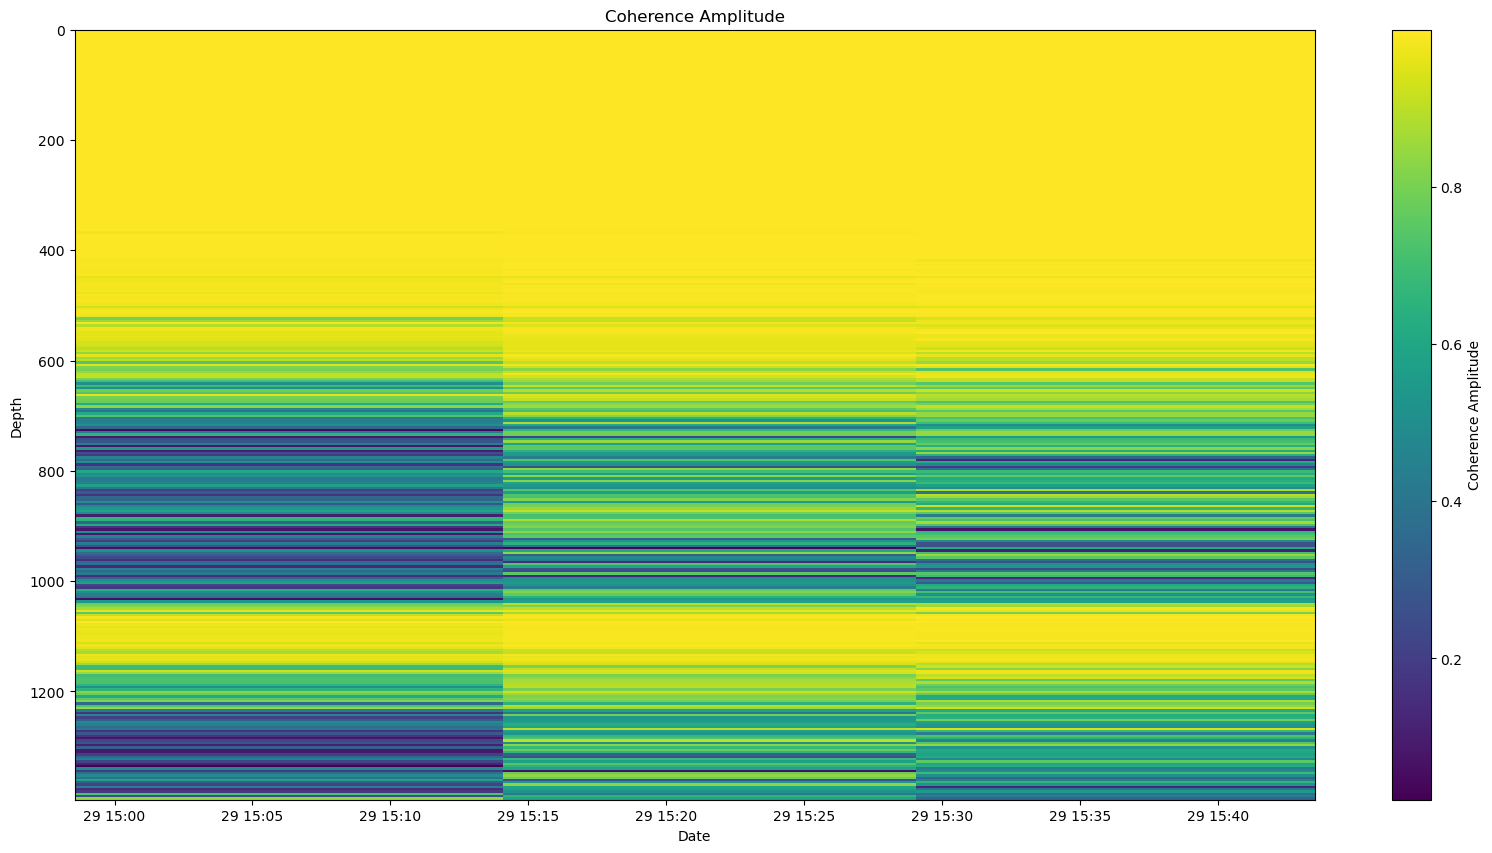

In [57]:
fig, ax = plt.subplots(figsize=(20,10))

im = plt.pcolormesh(t1,ds.values,abs(co).transpose())
fig.colorbar(im,label='Coherence Amplitude')
ax.invert_yaxis()
plt.ylabel('Depth')
plt.xlabel('Date')
plt.title('Coherence Amplitude')

Text(0.5, 1.0, 'Coherence Phase')

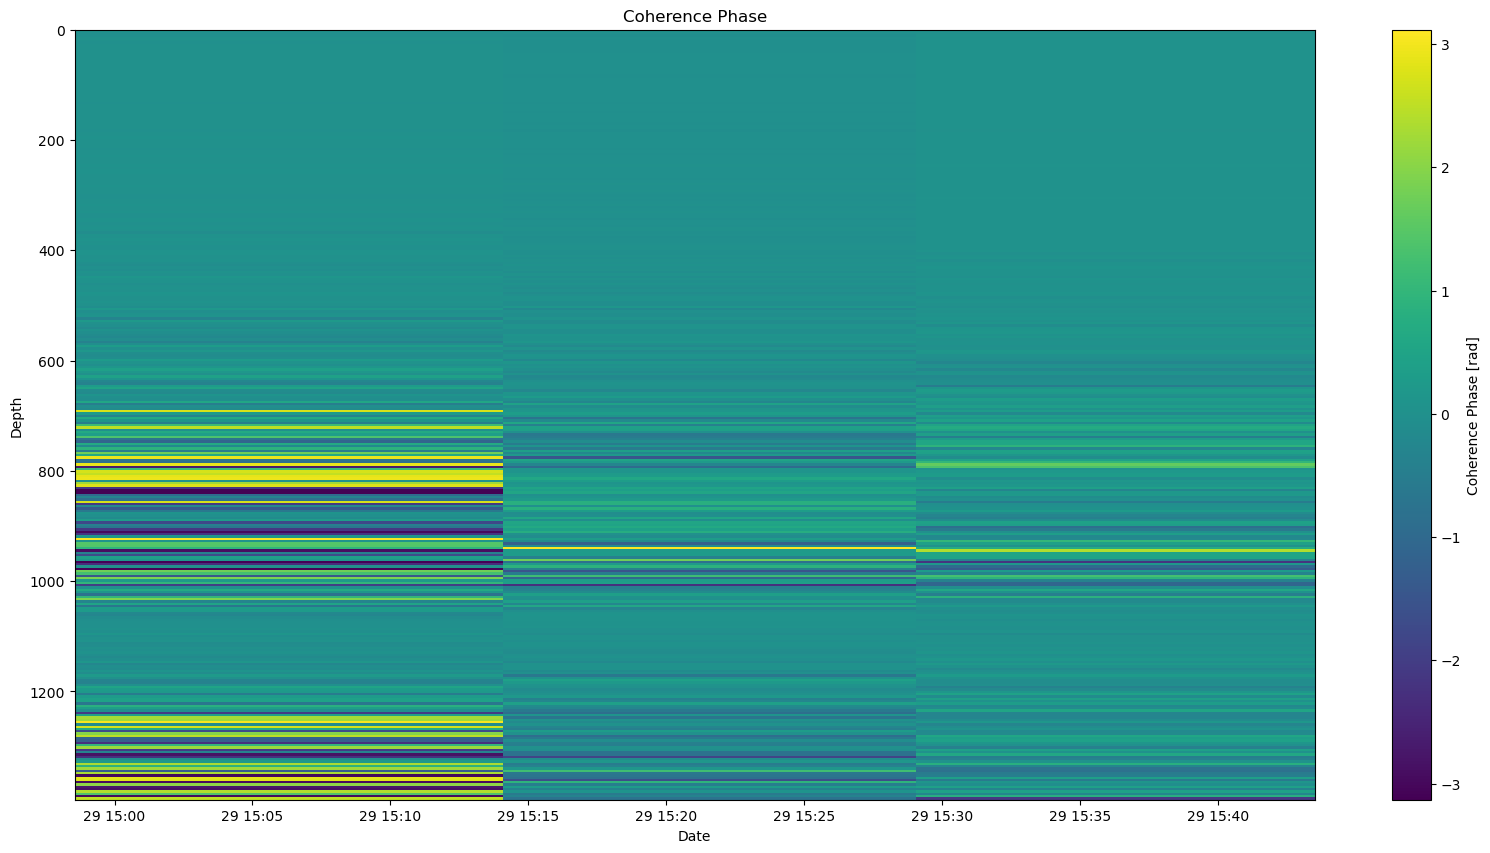

In [58]:
fig, ax = plt.subplots(figsize=(20,10))
phi = -np.angle(co).astype(float)
im = plt.pcolormesh(t1,ds.values,phi.transpose())
fig.colorbar(im,label='Coherence Phase [rad]')
ax.invert_yaxis()
plt.ylabel('Depth')
plt.xlabel('Date')
plt.title('Coherence Phase')

ImpDAR has a phase-wrapping step. I think it's for 

In [59]:
# Phase wrapping
win_wrap = 4
thresh = 1 #0.97
phi = -np.angle(co).astype(float)
for i in range(co.shape[1]-1):
    for t in range(co.shape[0]):
        idx = i+1
        if np.all(abs(co[t,idx-win_wrap:idx+win_wrap]) < thresh):
            continue
        elif phi[t,idx]-phi[t,idx-1] > np.pi:
            phi[t,idx:] -= 2.*np.pi
        elif phi[t,idx]-phi[t,idx-1] < -np.pi:
            phi[t,idx:] += 2.*np.pi

Text(0.5, 1.0, 'Coherence Phase')

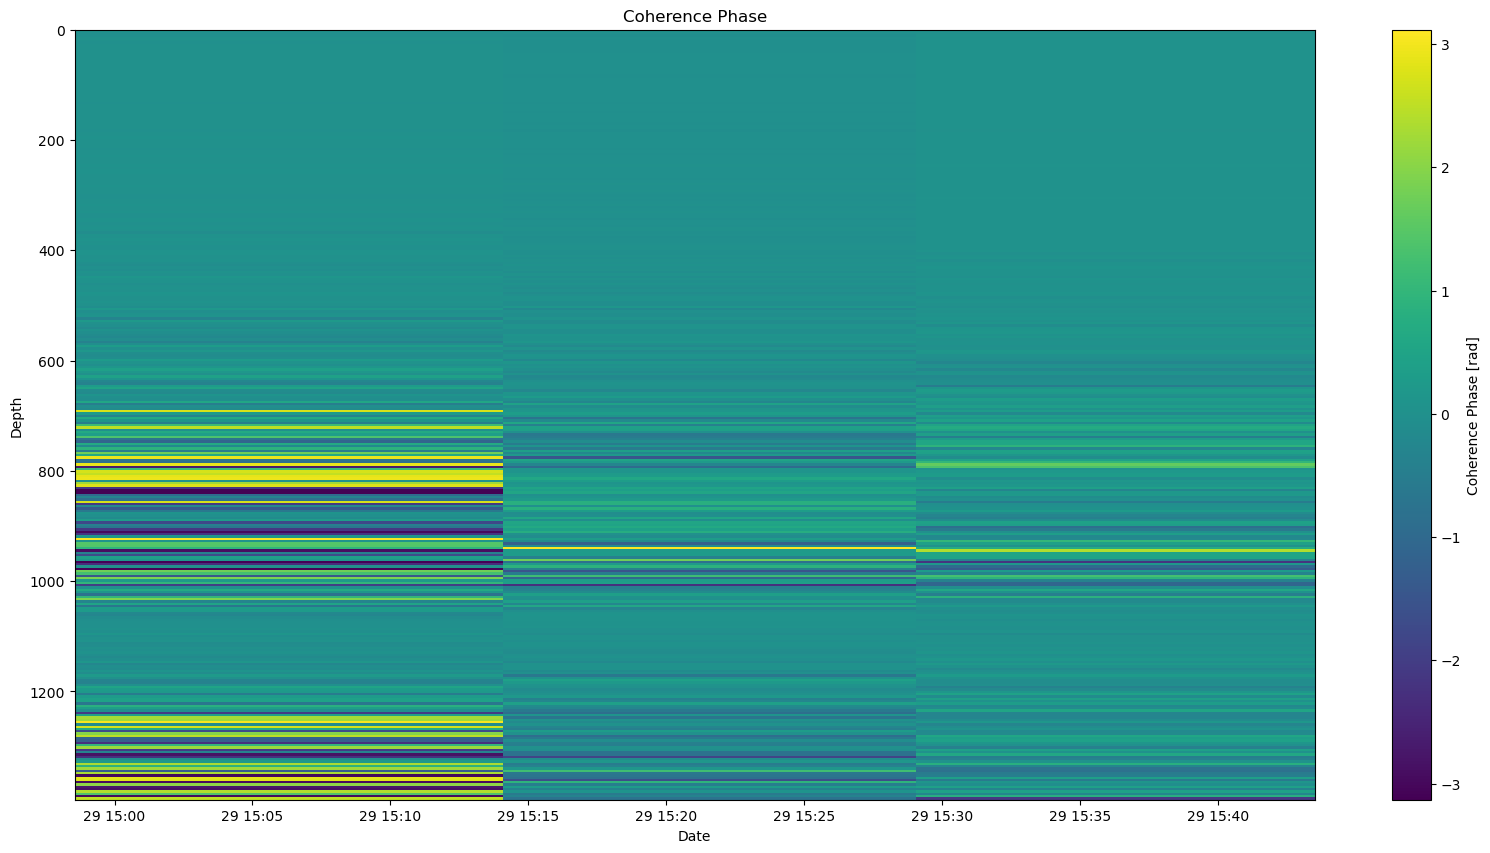

In [60]:
fig, ax = plt.subplots(figsize=(20,10))
im = plt.pcolormesh(t1,ds.values,phi.transpose())
fig.colorbar(im,label='Coherence Phase [rad]')
ax.invert_yaxis()
plt.ylabel('Depth')
plt.xlabel('Date')
plt.title('Coherence Phase')

In [61]:
def phase2range(phi, lambdac=0.5608, rc=None, K=2e8, ci=1.6823e8):
        """
        Convert phase difference to range for FMCW radar
        Parameters
        ---------
        lambdac: float
            wavelength (m) at center frequency
        rc: float; optional
            coarse range of bin center (m)
        K:  float; optional
            chirp gradient (rad/s/s)
        ci: float; optional
            propagation velocity (m/s)
        ### Original Matlab File Notes ###
        Craig Stewart
        2014/6/10
        """

        if not all([K,ci]) or rc is None:
            # First order method
            # Brennan et al. (2014) eq 15
            r = lambdac*phi/(4.*np.pi)
        else:
            # Precise
            r = phi/((4.*np.pi/lambdac) - (4.*rc[None,:]*K/ci**2.))

        return r


In [62]:
w = phase2range(phi,0.5608,ds.data,2e8, 1.6823e8)

Text(0.5, 1.0, 'Range difference [m]')

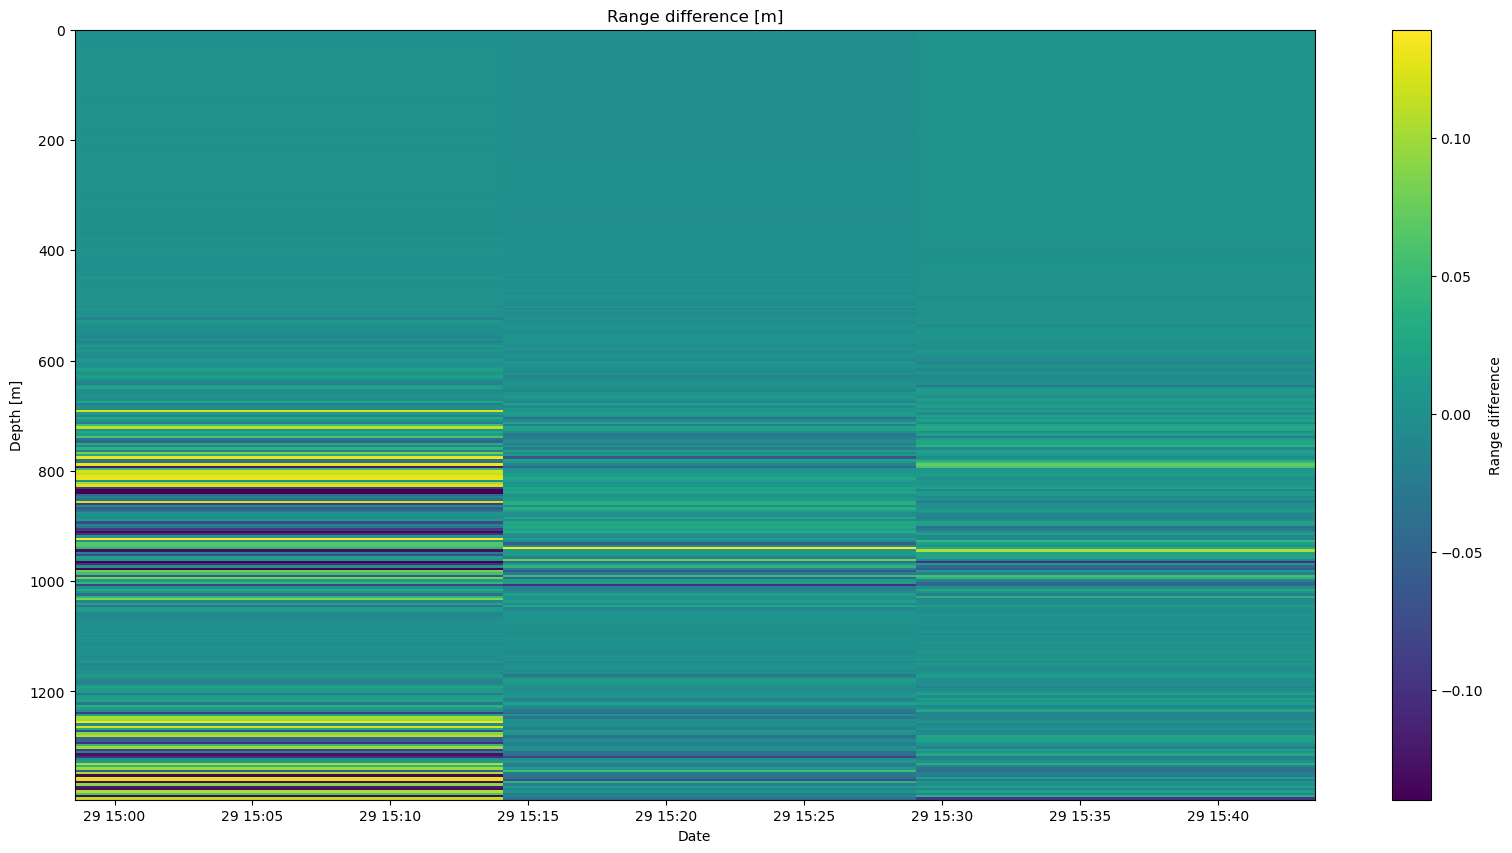

In [63]:
fig, ax = plt.subplots(figsize=(20,10))
im = plt.pcolormesh(t1,ds.values,w.transpose())
fig.colorbar(im,label='Range difference')
ax.invert_yaxis()
plt.ylabel('Depth [m]')
plt.xlabel('Date')
plt.title('Range difference [m]')

In [64]:
sigma = (1./abs(co))*np.sqrt((1.-abs(co)**2.)/(2.*win_cor))
# convert the phase offset to a distance vector
w_err = phase2range(sigma,
                        0.5608,
                        ds.data,
                        2e8,
                        1.6823e8)

In [65]:
coords = {'time':(['time'],t2,{'units': 'seconds','long_name':'Time of second burst'}),'profile_range':(['profile_range'],ds.profile_range.data,{'units': 'm','long_name':'Depth'})}
data_vars = {'time_diff':(['time'],np.cumsum(dt),{'units': 'seconds','long_name':'Time since first burst'}),
             'range_diff':(['time','profile_range'], w, #np.cumsum(w,axis=0), 
                 {'units': 'm', 
                  'long_name':'Range difference'}),
    'err':(['time','profile_range'], w_err, 
                 {'units': 'm', 
                  'long_name':'Error'})}
ds_xr = xr.Dataset(data_vars=data_vars, coords=coords)
ds_xr

<xarray.Dataset>
Dimensions:        (time: 3, profile_range: 332)
Coordinates:
  * time           (time) datetime64[ns] 2022-05-29T15:21:50 ... 2022-05-29T1...
  * profile_range  (profile_range) float64 2.103 6.309 ... 1.39e+03 1.394e+03
Data variables:
    time_diff      (time) float64 931.0 1.798e+03 2.7e+03
    range_diff     (time, profile_range) float64 2.617e-07 ... -0.09489
    err            (time, profile_range) float64 3.697e-06 0.0002501 ... 0.01989

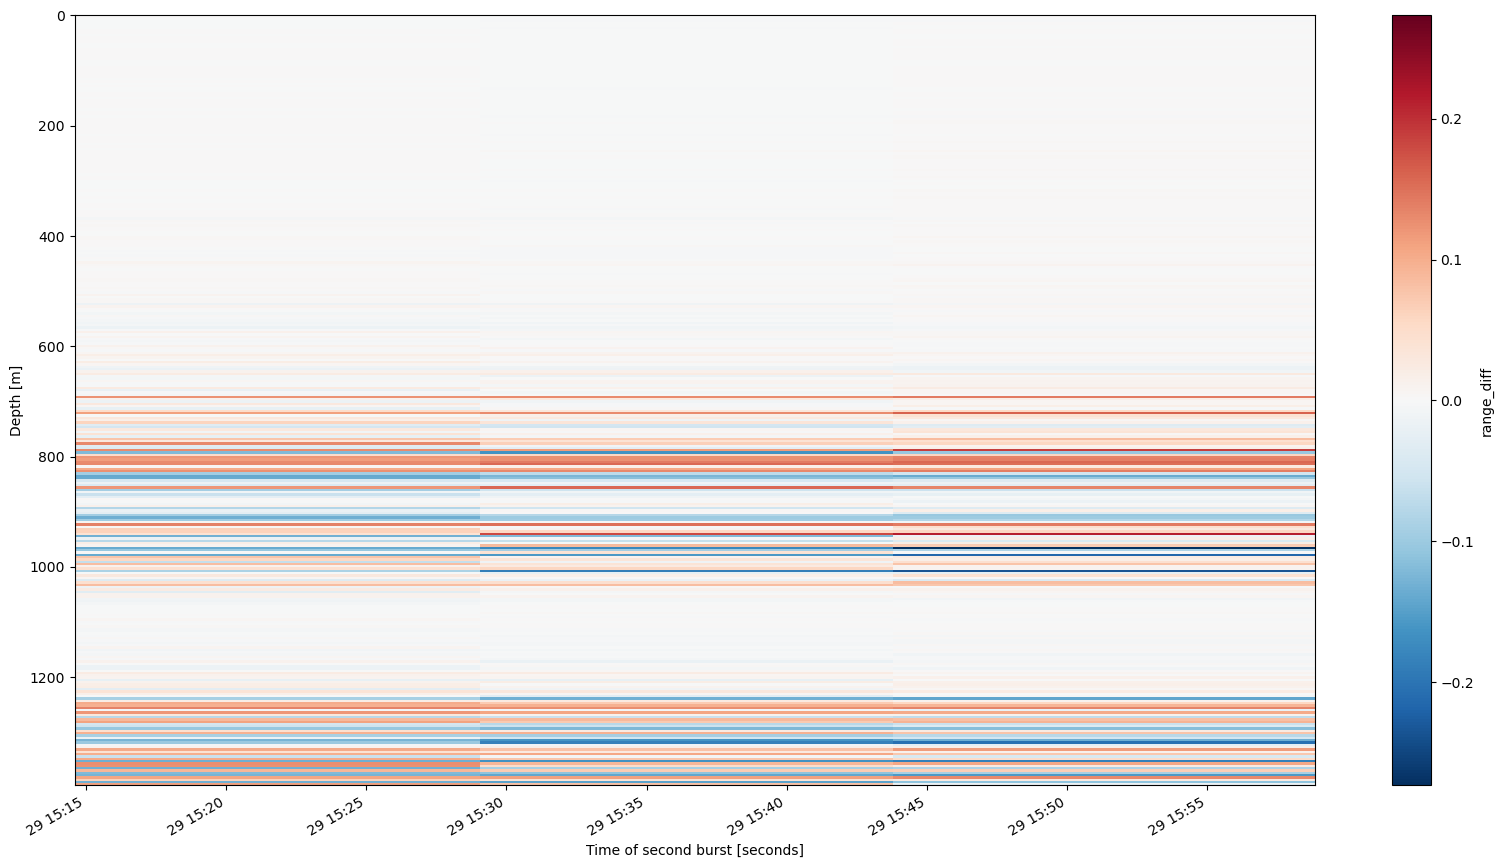

In [66]:
fig, ax = plt.subplots(figsize=(20,10))

ds_xr.range_diff.cumsum(dim='time').plot(ax=ax,x='time',cmap='RdBu_r')
ax.invert_yaxis()

In [25]:
def convert_to_seconds(s):
    seconds_per_unit = {"S": 1, "M": 60, "H": 3600, "D": 86400, "W": 604800}
    return int(s[:-1]) * seconds_per_unit[s[-1]]

def sum_error(errs):
    return np.sqrt(np.sum(errs**2))

def error_prop(data):
    return xr.apply_ufunc(sum_error, data, input_core_dims=[["time"]], vectorize = True)


In [26]:
disp_stack = ds_xr.range_diff.resample(time='2D').sum(dim='time')/convert_to_seconds('2D')*31536000
err_stack = ds_xr.err.resample(time='2D').apply(error_prop)/convert_to_seconds('2D')*31536000

In [27]:
strain_polyfit = disp_stack.where(disp_stack.profile_range < 500).polyfit('profile_range',1,w=1/err_stack.mean(dim='time'))

Text(0, 0.5, 'strain rate [y$^{-1}$]')

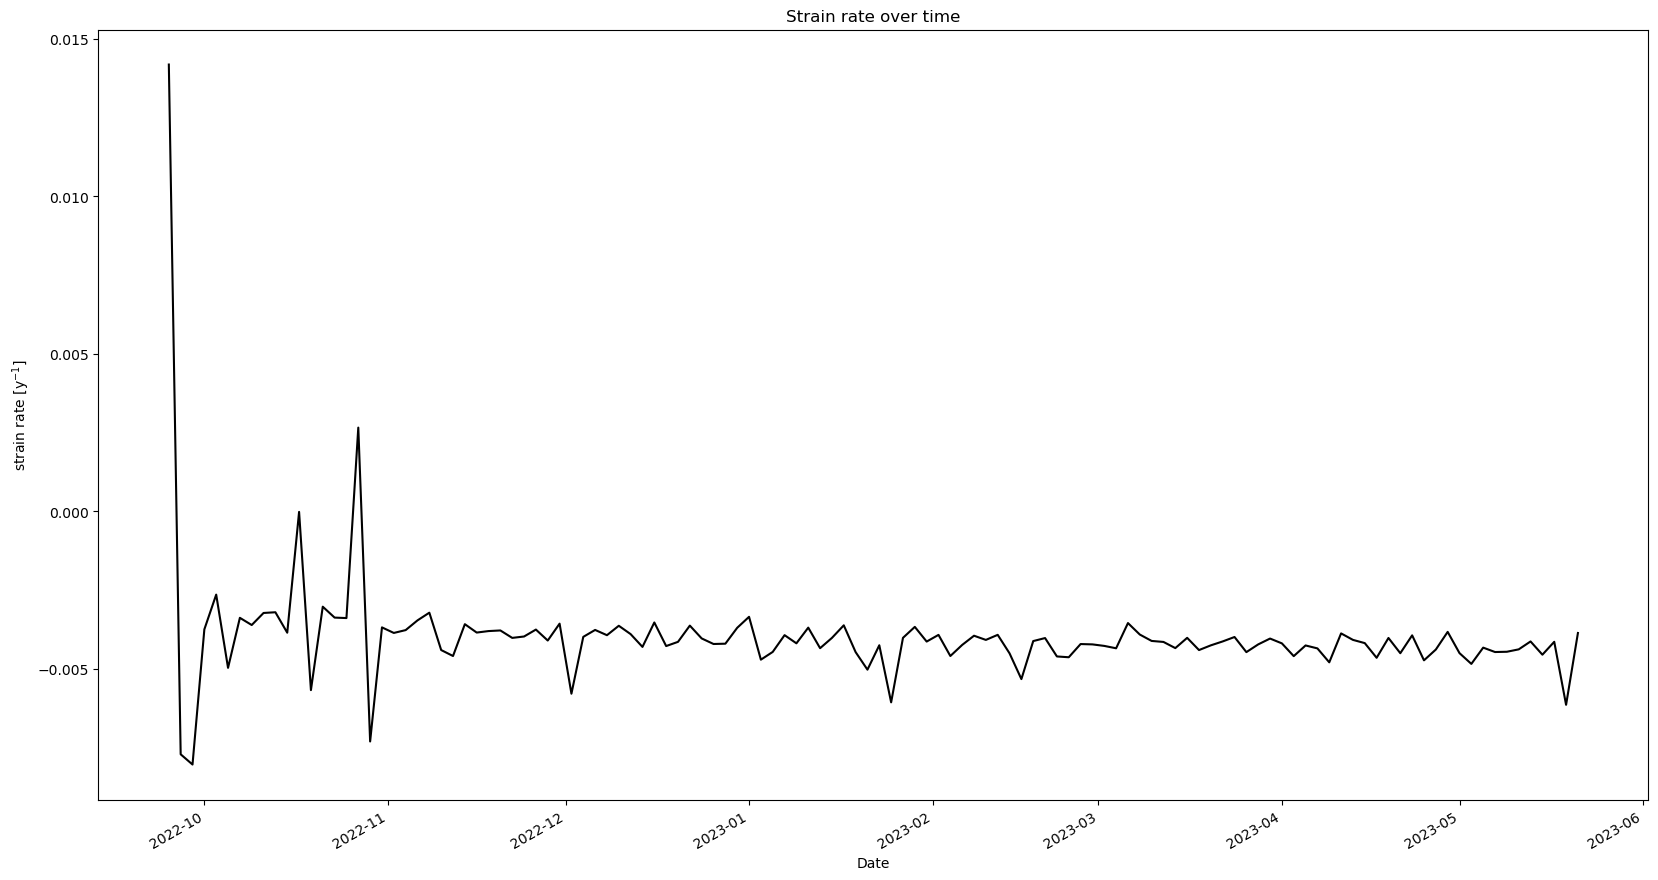

In [28]:
fig, ax = plt.subplots(figsize=(20,10))
strain_polyfit.polyfit_coefficients.sel(degree=1).plot(ax=ax,color='k')
ax.set_title('Strain rate over time')
ax.set_xlabel('Date')
ax.set_ylabel('strain rate [y$^{-1}$]')

Text(0.5, 0.01, 'vertical velocity [m y$^{-1}$]')

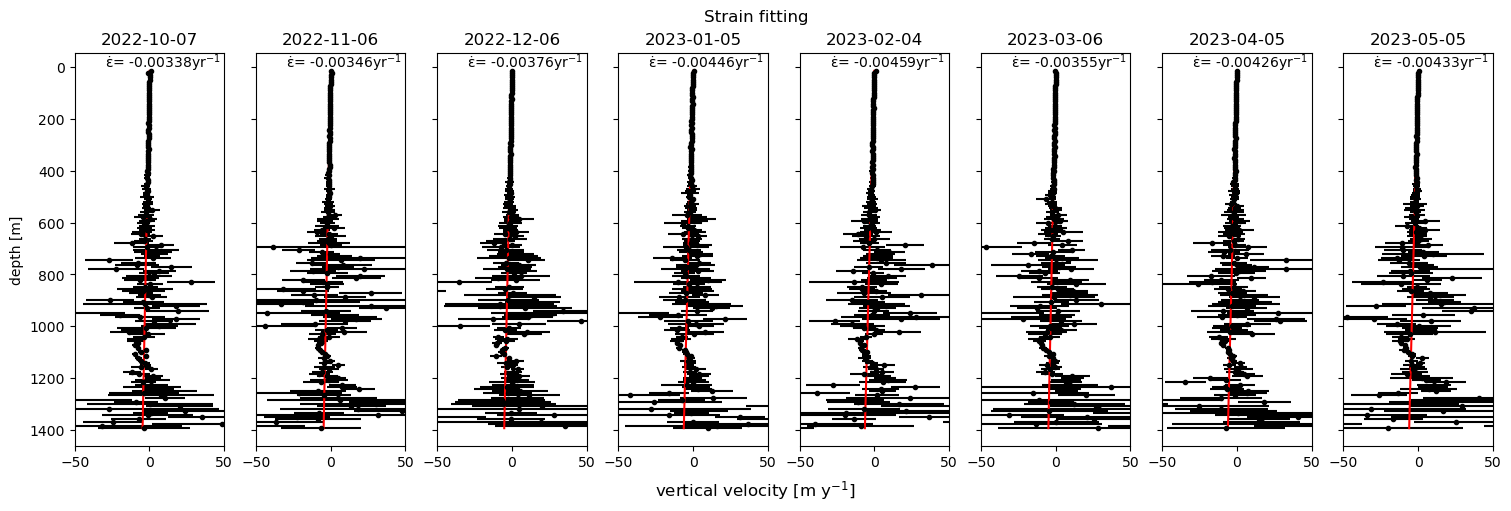

In [29]:
fig1, axs_1 = plt.subplots(ncols=8,figsize=(15,5),sharey=True,layout='constrained')
fig1.suptitle('Strain fitting')
# Plotting displacement for individual layers 
plt_count = 0
for i in np.arange(math.ceil(0.05*len(disp_stack.time)),len(disp_stack.time),len(disp_stack.time)//8):
    axs_1[plt_count].errorbar(disp_stack.isel(time = i) ,disp_stack.profile_range,yerr=None,xerr=err_stack.isel(time = i),linestyle='',marker='.',color='k')
    fit = strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i)*disp_stack.profile_range+strain_polyfit.polyfit_coefficients.sel(degree=0).isel(time=i)

    axs_1[plt_count].plot(fit,disp_stack.profile_range,color='r')
    unit = 'yr$^{-1}$'
    axs_1[plt_count].text(-30,0, f"\u03B5\u0307= {strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i).values:.3g}"+unit)
    axs_1[plt_count].set_title(f'{disp_stack.time.isel(time = i).values.astype(str)[:10]}')
    axs_1[plt_count].set_xlim([-50,50])
    plt_count += 1
    if plt_count == 8:
        break

axs_1[0].invert_yaxis()

axs_1[0].set_ylabel('depth [m]')
fig1.supxlabel('vertical velocity [m y$^{-1}$]')

Text(0.5, 0.01, 'date')

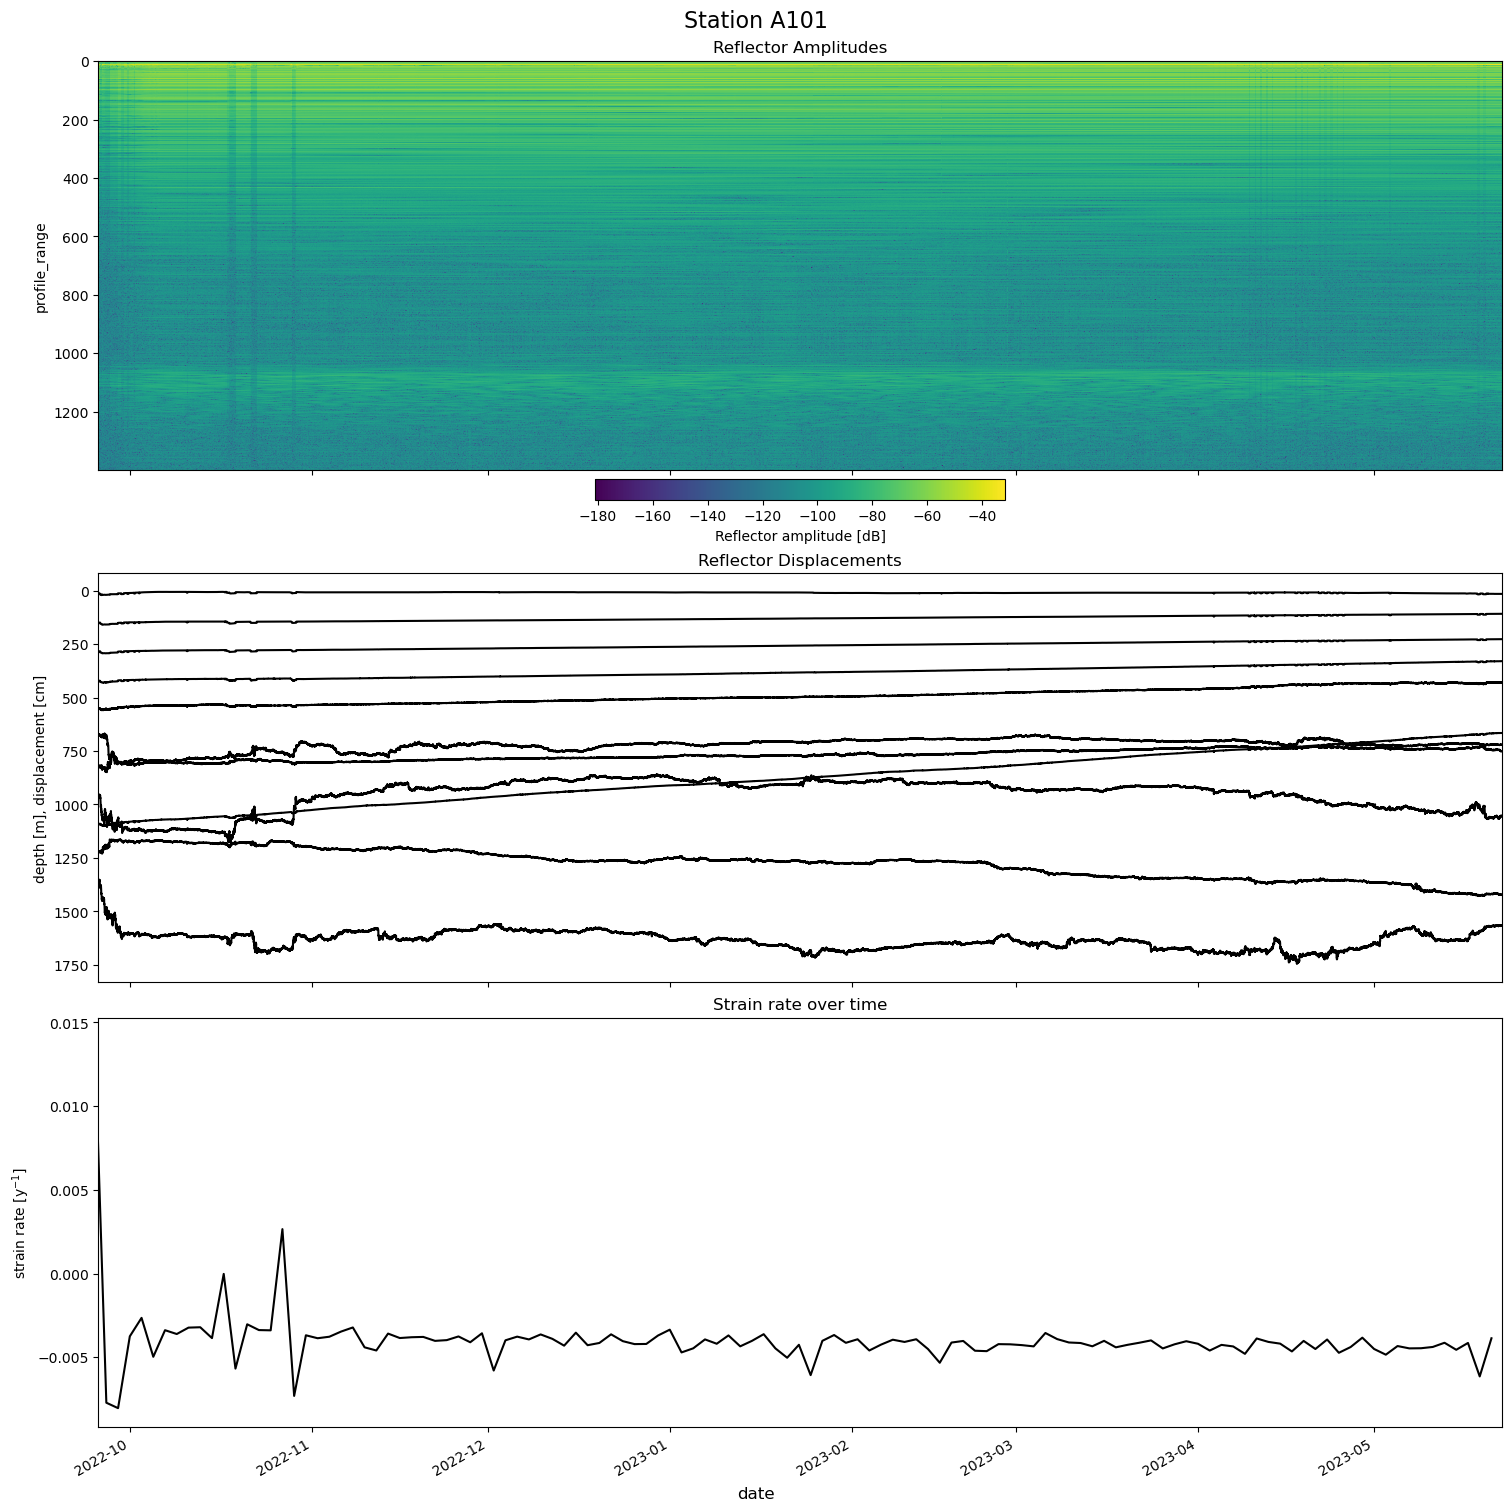

In [36]:
fig0, axs = plt.subplots(nrows=3,figsize=(15,15),sharex=True,layout='constrained')
fig0.suptitle(f'Station A101',fontsize=16)

profile_to_plot = xa.dB(da_101_stacked)
profile_to_plot.plot(ax=axs[0],x='time',cbar_kwargs={'location':'bottom','fraction':0.05,'pad':0.01,'label':'Reflector amplitude [dB]'})

axs[0].invert_yaxis()
axs[0].set_title('Reflector Amplitudes')
axs[0].set_xlabel('')

for i in np.arange(0,len(ds_xr.profile_range),len(ds_xr.profile_range)//10):
    (100*ds_xr.range_diff.cumsum(dim='time').isel(profile_range = i) + ds_xr.profile_range.isel(profile_range = i)).plot(ax=axs[1],color='k')
axs[1].invert_yaxis()
axs[1].set_title('Reflector Displacements')
axs[1].set_xlabel('')
axs[1].set_ylabel('depth [m], displacement [cm]')


strain_polyfit.polyfit_coefficients.sel(degree=1).plot(ax=axs[2],color='k')
axs[2].set_title('Strain rate over time')
axs[2].set_xlabel('')
axs[2].set_ylabel('strain rate [y$^{-1}$]')

fig0.supxlabel('date')